In [ ]:
#@title Uploading the three files
from google.colab import files
uploaded = files.upload()

In [26]:
#@title Joining both dataframes
import pandas as pd
trn = pd.read_csv('glitch_trn_data.csv')
label=pd.read_csv('glitch_trn_class_labels.csv',names=["D_value","Type"])

dataset=pd.concat([trn,label],axis=1)
dataset=dataset.dropna().drop("D_value",axis=1).drop("id",axis=1)

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
#@title Visualisation

h1df=pd.DataFrame(columns=dataset.columns)
l1df=pd.DataFrame(columns=dataset.columns)
for row in dataset.values:
  #print(row)
  if row[4] == "H1":
    h1df.loc[len(h1df)]=row
  elif row[4] == "L1":
    l1df.loc[len(l1df)]=row
tmpstr="1080Lines,1400Ripples,Air_Compressor,Blip,Chirp,Extremely_Loud,Helix,Koi_Fish,Light_Modulation,Low_Frequency_Burst,Low_Frequency_Lines,No_Glitch,None_of_the_Above,Paired_Doves,Power_Line,Repeating_Blips,Scattered_Light,Scratchy,Tomte,Violin_Mode,Wandering_Line,Whistle"
array_all_glitch_types=tmpstr.split(",")
array_occurences_df=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
array_occurences_h1df=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
array_occurences_l1df=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for row in dataset.values:
  index=array_all_glitch_types.index(row[-1])
  array_occurences_df[index]= array_occurences_df[index]+1

for row in h1df.values:
  index=array_all_glitch_types.index(row[-1])
  array_occurences_h1df[index]= array_occurences_h1df[index]+1

for row in l1df.values:
  index=array_all_glitch_types.index(row[-1])
  array_occurences_l1df[index]= array_occurences_l1df[index]+1




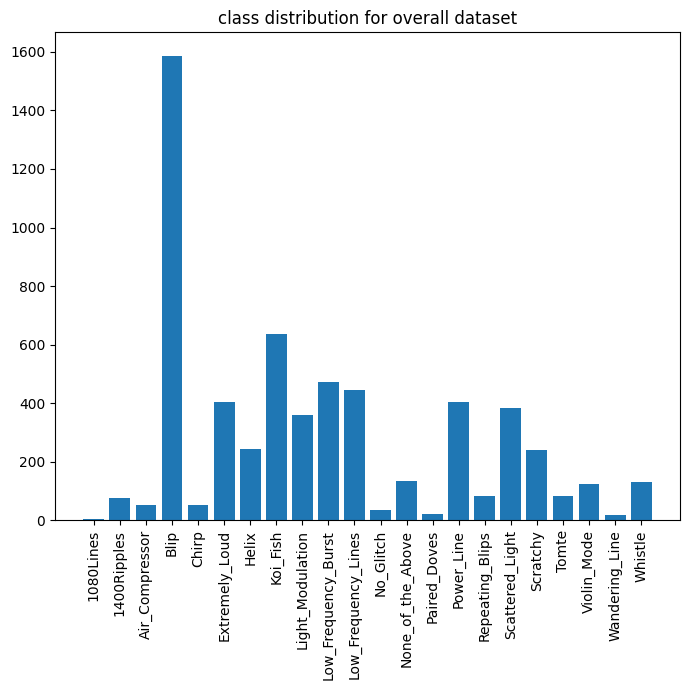

In [29]:
#@title class distribution for overall dataset
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.title("class distribution for overall dataset")
# List of data points
#data = [0, 1, 3, 2, 1, 5, 2, 1, 4, 2, 4, 0]

# Plot bar chart with data points
plt.bar(array_all_glitch_types, array_occurences_df)

plt.xticks(rotation=90)
# Display the plot
plt.show()


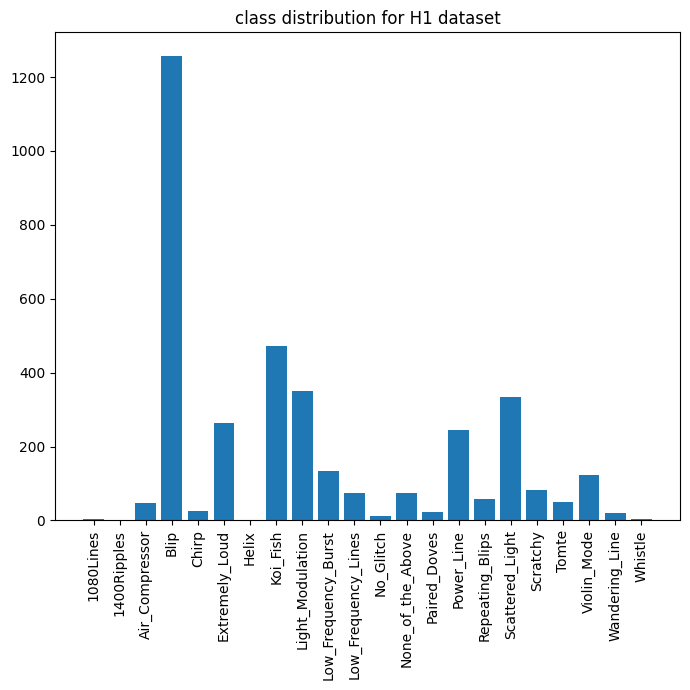

In [30]:
#@title class distribution for H1 dataset
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.title("class distribution for H1 dataset")
# List of data points
#data = [0, 1, 3, 2, 1, 5, 2, 1, 4, 2, 4, 0]

# Plot bar chart with data points
plt.bar(array_all_glitch_types, array_occurences_h1df)

plt.xticks(rotation=90)
# Display the plot
plt.show()


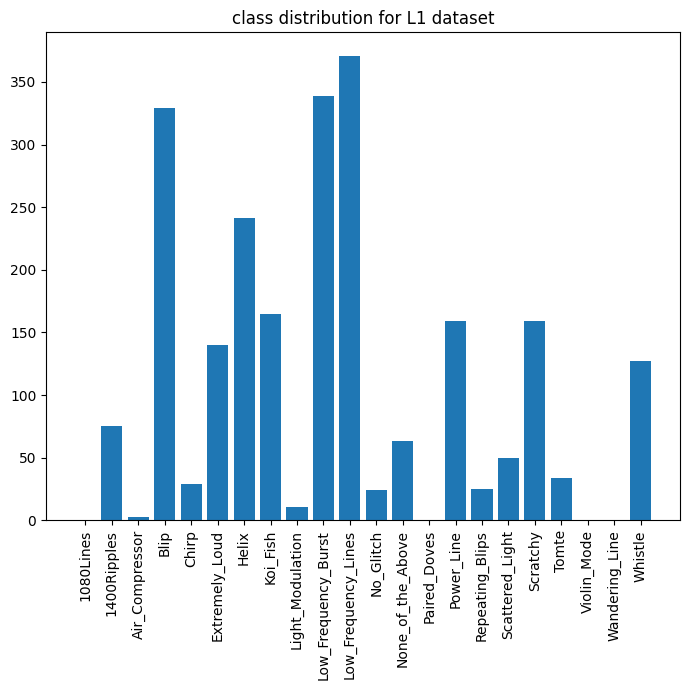

In [31]:
#@title class distribution for L1 dataset
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.title("class distribution for L1 dataset")
# List of data points
#data = [0, 1, 3, 2, 1, 5, 2, 1, 4, 2, 4, 0]

# Plot bar chart with data points
plt.bar(array_all_glitch_types, array_occurences_l1df)

plt.xticks(rotation=90)
# Display the plot
plt.show()


Without Normalisation and without taking ifo into account

In [69]:
#@title check scores after running gridsearch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import svm

df1=dataset.drop("ifo",axis=1)

X = df1.drop("Type",axis=1)
y = df1["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before gridsearch, Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [10, 50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg'],
            'max_iter': [100, 500, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before gridsearch, Model: DecisionTreeClassifier | Precision: 0.7358630487367921 | Recall: 0.702499253883385 | F-measure: 0.7096398162796718
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10}
After gridsearch Model: DecisionTreeClassifier | Precision: 0.722636972102827 | Recall: 0.6721081053589054 | F-measure: 0.6876932676113272

Before gridsearch, Model: RandomForestClassifier | Precision: 0.8522639021683239 | Recall: 0.7277307438740586 | F-measure: 0.750380438862961
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
After gridsearch Model: RandomForestClassifier | Precision: 0.7852220182850401 | Recall: 0.7196798172657669 | F-measure: 0.7332681619882359

Before gridsearch, Model: KNeighborsClassifier | Precision: 0

from sklearn import svm
model_svm=svm.SVC(C=1000,kernel='linear',random_state=10)

model_svm.fit(X_train,y_train)

y_pred= model_svm.predict(X_test)
y_pred

Without normalisation but taking ifo into account

In [ ]:
pip install category_encoders

In [70]:
#@title onehot encoding
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df2=dataset
df2encoded=encoder.fit_transform(df2)


In [72]:
#@title check scores after running gridsearch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X = df2encoded.drop("Type",axis=1)
y = df2encoded["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [10, 50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg'],
            'max_iter': [100, 500, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After Griddsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.6870891606990662 | Recall: 0.6878014531811443 | F-measure: 0.6854908722202631
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
After Griddsearch Model: DecisionTreeClassifier | Precision: 0.7748450287331281 | Recall: 0.7398892788693427 | F-measure: 0.7510363889828789

Before Gridsearch Model: RandomForestClassifier | Precision: 0.8197054018657984 | Recall: 0.7199821296197009 | F-measure: 0.7405163660429498
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
After Griddsearch Model: RandomForestClassifier | Precision: 0.8334858728852746 | Recall: 0.7378296690072339 | F-measure: 0.7592713178343466

Before Gridsearch Model: KNeighborsClassifier | Precision: 0.

With Normalisation and without taking ifo into account

In [73]:
#@title normalization routine
train_stats= dataset.describe()
train_stats=train_stats.transpose()
train_stats

def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

df3=dataset.drop("ifo",axis=1)
df3normed=norm(df3.drop("Type",axis=1))
df3normed["Type"]=dataset["Type"]
print(df3normed)

       GPStime  centralFreq  peakFreq       snr  bandwidth  duration  \
0    -0.735491    -0.881296  0.055403 -0.101788  -0.853078 -0.569921   
1     1.197329     1.578602 -0.444086  1.717514   1.603914  4.437004   
2    -0.645588     0.235766  4.854946 -0.114703   0.253444 -0.523354   
3    -0.023711     0.409667 -0.249164 -0.117371   0.424081 -0.623939   
4    -0.277556     1.857675 -0.193720 -0.118581   1.823587  0.195274   
...        ...          ...       ...       ...        ...       ...   
5995  1.693019     0.170028  3.526276 -0.116821  -0.547602 -0.636978   
5996  1.049778     0.687468 -0.517483 -0.117708   0.720299  0.361427   
5997  0.454562     0.419919 -0.459098 -0.115614   0.443184  0.137158   
5998  0.303646    -0.810081  0.527608 -0.119675  -0.807318 -0.648527   
5999  1.507794     1.085843 -0.508772 -0.115819   1.113811  0.454561   

                     Type  
0                    Blip  
1          Extremely_Loud  
2             Violin_Mode  
3                    Bl

In [75]:
#@title check scores after gridsearch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X = df3normed.drop("Type",axis=1)
y = df3normed["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [10, 50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg'],
            'max_iter': [100, 500, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before gridsearch Model: DecisionTreeClassifier | Precision: 0.7036156504098978 | Recall: 0.7186872902187779 | F-measure: 0.7082215715979424
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}
After gridsearch Model: DecisionTreeClassifier | Precision: 0.7157484711455255 | Recall: 0.7183941003741944 | F-measure: 0.7130424930749457

Before gridsearch Model: RandomForestClassifier | Precision: 0.8143712061026828 | Recall: 0.7591396578319114 | F-measure: 0.7765786522236201
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
After gridsearch Model: RandomForestClassifier | Precision: 0.812736029961162 | Recall: 0.7505542492206786 | F-measure: 0.7698557858324552

Before gridsearch Model: KNeighborsClassifier | Precision: 0.6

with normalization but taking ifo into account

In [76]:
#@title normalization routine
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df4=dataset
df4encoded=encoder.fit_transform(df4)

train_stats= df4encoded.describe()
train_stats=train_stats.transpose()
train_stats


def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

df4normed=norm(df4encoded.drop("Type",axis=1))
df4normed["Type"]=dataset["Type"]


In [77]:
#@title check scores after gridsearch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X = df4normed.drop("Type",axis=1)
y = df4normed["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [10, 50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg'],
            'max_iter': [100, 500, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.7055214202605632 | Recall: 0.7099900233558365 | F-measure: 0.7047593772261679
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
After gridsearch Model: DecisionTreeClassifier | Precision: 0.7544788772204328 | Recall: 0.7895666601006912 | F-measure: 0.75864933689291

Before Gridsearch Model: RandomForestClassifier | Precision: 0.8306846340650714 | Recall: 0.7610381733877177 | F-measure: 0.7809628747320118
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
After gridsearch Model: RandomForestClassifier | Precision: 0.8319445405741358 | Recall: 0.7647506041029035 | F-measure: 0.7853185822427999

Before Gridsearch Model: KNeighborsClassifier | Precision: 0

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df4=dataset
df4encoded=encoder.fit_transform(df4)

train_stats= df4encoded.describe()
train_stats=train_stats.transpose()
train_stats


def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

df4normed=norm(df4encoded.drop("Type",axis=1))
df4normed["Type"]=dataset["Type"]

X = df4normed.drop("Type",axis=1)
y = df4normed["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

dt=DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2)
dt.fit(X_train, y_train)

tstdata=pd.read_csv('glitch_tst_data.csv')
test_ids = tstdata['id']
#tstdata[["", "C"]] = tstdata[["C", "B"]]

x_test_unknown=tstdata.drop("id",axis=1)
x_test_unknown=encoder.fit_transform(x_test_unknown)
h1=x_test_unknown["ifo_H1"]
l1=x_test_unknown["ifo_H1"]
bw=x_test_unknown["ifo_L1"]
dur=x_test_unknown["ifo_L1"]
x_test_unknown=x_test_unknown.drop("ifo_H1",axis=1)
x_test_unknown=x_test_unknown.drop("ifo_L1",axis=1)
x_test_unknown=x_test_unknown.drop("bandwidth",axis=1)
x_test_unknown=x_test_unknown.drop("duration",axis=1)

x_test_unknown["ifo_L1"]=l1
x_test_unknown["ifo_H1"]=h1
x_test_unknown["bandwidth"]=bw
x_test_unknown["duration"]=dur

predictions=dt.predict(x_test_unknown)
results_df = pd.DataFrame({'id': test_ids, 'predicted_class': predictions})

In [ ]:
print(x_test_unknown)
#print(tstdata)
print(h1)
print(X_train)

In [ ]:
print(results_df)

In [108]:
results_df.to_csv('my_dataframe.csv', index=True)